### Analysis for InSAR-derived PWV by COSMIC-GPS

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
#import cfgrib
#import cf2cdm
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from datetime import datetime, timedelta
import urllib.request
#from cfgrib.xarray_store import open_dataset
import warnings
import h5py
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

In [18]:
import scipy.signal as signal
import scipy.fft as fft
from skimage.feature import match_template

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
warnings.filterwarnings('ignore')

In [4]:
pwv_insar_abs = xr.open_dataset('/data2/willytsai/InSAR_HRRR/InSAR_derived_PWV_NEVADA.nc')

In [5]:
pwv_insar_abs

<xarray.Dataset>
Dimensions:    (latitude: 2399, longitude: 1742, time: 99)
Coordinates:
  * time       (time) datetime64[ns] 2015-03-22T02:00:00 ... 2019-12-20T02:00:00
  * latitude   (latitude) float64 37.23 37.23 37.23 37.24 ... 43.22 43.22 43.22
  * longitude  (longitude) float64 -119.0 -119.0 -119.0 ... -114.7 -114.7 -114.7
Data variables:
    pwat       (time, latitude, longitude) float64 ...

In [6]:
pwv_hrrr_abs = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/google_archive/regrid_3km/HRRR_pwat_NEVADA.nc')

In [7]:
pwv_hrrr_abs

<xarray.Dataset>
Dimensions:    (latitude: 200, longitude: 145, time: 118)
Coordinates:
  * time       (time) datetime64[ns] 2015-03-22T02:00:00 ... 2020-10-03T02:00:00
  * latitude   (latitude) float64 37.25 37.28 37.31 37.34 ... 43.16 43.19 43.22
  * longitude  (longitude) float64 -119.0 -118.9 -118.9 ... -114.7 -114.7 -114.7
Data variables:
    pwat       (time, latitude, longitude) float64 ...

In [8]:
# get geolocation from InSAR
geo_file = '/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/geometryRadar.h5'
geo = h5py.File(geo_file,'r')
# for key in geo.keys():
#     print(key) #Names of the groups in HDF5 file.
lat = geo['latitude'];
lon = geo['longitude'];
incidence = geo['incidenceAngle'];
axis_bound = [np.min(lat),np.max(lat),np.min(lon),np.max(lon)]; # coordinate bound [South,North,West,East]
axis_bound = [np.unique(lat.value)[1],np.unique(lat.value)[-1],np.unique(lon.value)[0],np.unique(lon.value)[-2]]

In [9]:
def remap_hrrr2SAR(hrrr_2dmap):
    "regrid hrrr data into SAR"
    lon_hrrr,lat_hrrr = np.meshgrid(hrrr_2dmap.longitude.values,hrrr_2dmap.latitude.values)
    lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
    points = np.stack([lon_hrrr.ravel(),lat_hrrr.ravel()]).swapaxes(0,1)
    var_remap = griddata(points, hrrr_2dmap.values.ravel(), (lon_isar, lat_isar), method='linear')

    return var_remap

In [10]:
# the reference point on InSAR map, near P002
data_ifgrams = h5py.File('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/S1_IW123_166_0121_0140_20150322_XXXXXXXX.he5', 'r')
geo_info = data_ifgrams['HDFEOS']['GRIDS']['timeseries']['geometry']
lon_ifgrams = geo_info['longitude']
lat_ifgrams = geo_info['latitude']

lon_sar = np.linspace(axis_bound[2],axis_bound[3],lon_ifgrams.shape[1])
lat_sar = np.linspace(axis_bound[0],axis_bound[1],lon_ifgrams.shape[0])

idx = find_nearest(lon_sar,-117.168465)
idy = find_nearest(lat_sar,38.228363)

In [11]:
pwv_insar_abs

<xarray.Dataset>
Dimensions:    (latitude: 2399, longitude: 1742, time: 99)
Coordinates:
  * time       (time) datetime64[ns] 2015-03-22T02:00:00 ... 2019-12-20T02:00:00
  * latitude   (latitude) float64 37.23 37.23 37.23 37.24 ... 43.22 43.22 43.22
  * longitude  (longitude) float64 -119.0 -119.0 -119.0 ... -114.7 -114.7 -114.7
Data variables:
    pwat       (time, latitude, longitude) float64 ...

Text(0.5, 1.0, 'HRRR PWV \n 2019-12-20T02:00:00')

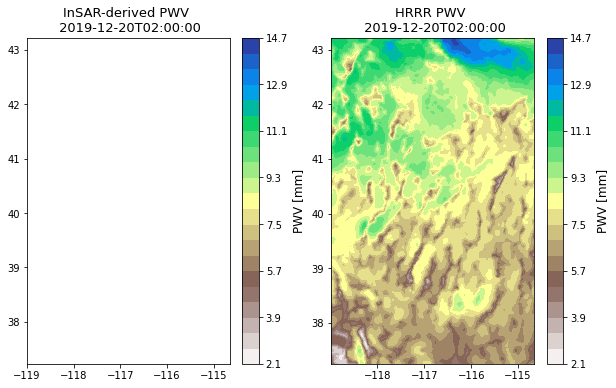

In [12]:
t = 98

fig,ax = plt.subplots(1,2,figsize=(10,6))

cf0 = plt.contourf(pwv_hrrr_abs.longitude,pwv_hrrr_abs.latitude,pwv_hrrr_abs.pwat[t,:,:],levels=20,
                    cmap='terrain_r')

cf1 = ax[0].contourf(pwv_insar_abs.longitude,pwv_insar_abs.latitude,pwv_insar_abs.pwat[t,:,:]
                     ,levels=cf0.cvalues,cmap='terrain_r')
cf2 = ax[1].contourf(pwv_hrrr_abs.longitude,pwv_hrrr_abs.latitude,pwv_hrrr_abs.pwat[t,:,:]
                     ,levels=cf0.cvalues,cmap='terrain_r')
cbar1 = plt.colorbar(cf1,ax=ax[0]);cbar1.set_label('PWV [mm]',fontsize=12)
cbar2 = plt.colorbar(cf2,ax=ax[1]);cbar2.set_label('PWV [mm]',fontsize=12)

ax[0].set_title('InSAR-derived PWV \n '+ str(pwv_insar_abs.time[t].values)[:-10],fontsize=13)
ax[1].set_title('HRRR PWV \n '+ str(pwv_insar_abs.time[t].values)[:-10],fontsize=13)

In [13]:
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# os.chdir('/data2/willytsai/InSAR_HRRR/')
# with PdfPages('InSAR_HRRR_PWV_compare_NEVADA.pdf') as pdf:
#     for t in range(pwv_insar_abs.pwat.shape[0]):
        
#         fig,ax = plt.subplots(1,2,figsize=(10,6))
#         cf0 = plt.contourf(pwv_hrrr_abs.longitude,pwv_hrrr_abs.latitude,pwv_hrrr_abs.pwat[t,:,:],levels=20,
#                             cmap='terrain_r')

#         cf1 = ax[0].contourf(pwv_insar_abs.longitude,pwv_insar_abs.latitude,pwv_insar_abs.pwat[t,:,:]
#                              ,levels=cf0.cvalues,cmap='terrain_r')
#         cf2 = ax[1].contourf(pwv_hrrr_abs.longitude,pwv_hrrr_abs.latitude,pwv_hrrr_abs.pwat[t,:,:]
#                              ,levels=cf0.cvalues,cmap='terrain_r')
#         cbar1 = plt.colorbar(cf1,ax=ax[0]);cbar1.set_label('PWV [mm]',fontsize=12)
#         cbar2 = plt.colorbar(cf2,ax=ax[1]);cbar2.set_label('PWV [mm]',fontsize=12)

#         ax[0].set_title('InSAR-derived PWV \n '+ str(pwv_insar_abs.time[t].values)[:-10],fontsize=13)
#         ax[1].set_title('HRRR PWV \n '+ str(pwv_insar_abs.time[t].values)[:-10],fontsize=13)
        
#         pdf.savefig(fig)

In [14]:
pwv_hrrr_abs.pwat.shape

(118, 200, 145)

In [29]:
# 1-D power spectrum test
data_test = pwv_hrrr_abs.pwat[30,:,67].values
data_test2 = pwv_insar_abs.pwat[30,:,800].values

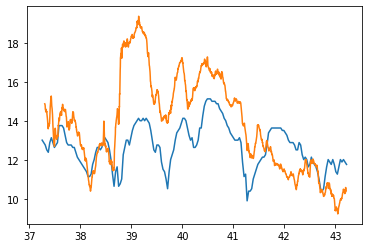

In [33]:
plt.plot(pwv_hrrr_abs.latitude,data_test)
plt.plot(pwv_insar_abs.latitude,data_test2)

In [20]:
f, Pxx_den = signal.periodogram(data_test, 1/3)

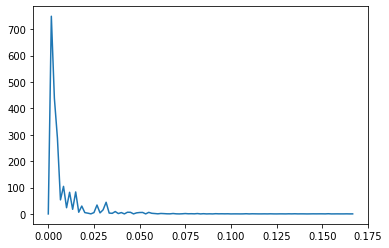

In [21]:
plt.plot(f,Pxx_den)

In [22]:
1/f

array([         inf, 600.        , 300.        , 200.        ,
       150.        , 120.        , 100.        ,  85.71428571,
        75.        ,  66.66666667,  60.        ,  54.54545455,
        50.        ,  46.15384615,  42.85714286,  40.        ,
        37.5       ,  35.29411765,  33.33333333,  31.57894737,
        30.        ,  28.57142857,  27.27272727,  26.08695652,
        25.        ,  24.        ,  23.07692308,  22.22222222,
        21.42857143,  20.68965517,  20.        ,  19.35483871,
        18.75      ,  18.18181818,  17.64705882,  17.14285714,
        16.66666667,  16.21621622,  15.78947368,  15.38461538,
        15.        ,  14.63414634,  14.28571429,  13.95348837,
        13.63636364,  13.33333333,  13.04347826,  12.76595745,
        12.5       ,  12.24489796,  12.        ,  11.76470588,
        11.53846154,  11.32075472,  11.11111111,  10.90909091,
        10.71428571,  10.52631579,  10.34482759,  10.16949153,
        10.        ,   9.83606557,   9.67741935,   9.52

### InSAR PWV and HRRR PWV cospectral analysis


In [34]:
pwv_hrrr_abs.pwat[30,:,:]

<xarray.DataArray 'pwat' (latitude: 200, longitude: 145)>
array([[18.887589, 20.512589, 19.387589, ...,  9.512588,  9.887588, 10.262588],
       [20.012589, 19.512589, 14.262588, ...,  8.762588,  9.137588,  9.637588],
       [20.762589, 18.512589, 15.012588, ...,  7.387588,  8.012588,  8.387588],
       ...,
       [11.762588, 11.762588, 11.887588, ..., 12.762588, 12.762588, 12.887588],
       [11.762588, 11.887588, 12.012588, ..., 12.637588, 12.637588, 12.512588],
       [12.012588, 12.012588, 12.137588, ..., 12.512588, 12.637588, 12.637588]])
Coordinates:
    time       datetime64[ns] 2017-08-20T02:00:00
  * latitude   (latitude) float64 37.25 37.28 37.31 37.34 ... 43.16 43.19 43.22
  * longitude  (longitude) float64 -119.0 -118.9 -118.9 ... -114.7 -114.7 -114.7

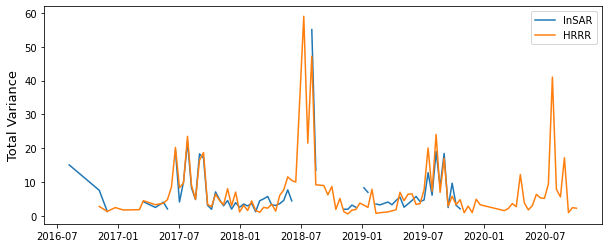

In [189]:
# total variance 
fig = plt.figure(figsize=(10,4))

plt.plot(pwv_insar_abs.pwat.time.values,pwv_insar_abs.pwat.var(axis=(1,2)),label='InSAR')
plt.plot(pwv_hrrr_abs.pwat.time.values,pwv_hrrr_abs.pwat.var(axis=(1,2)),label='HRRR')
#plt.xlim([0,99])
plt.ylabel('Total Variance',fontsize=13)
plt.legend()

In [39]:
insar_test = pwv_insar_abs.pwat[50,:,:].fillna(0)
hrrr_test = remap_hrrr2SAR(pwv_hrrr_abs.pwat[50,:,:])
hrrr_test[insar_test==0] = 0

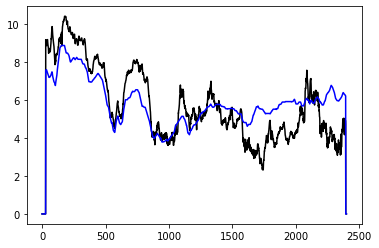

In [40]:
plt.plot(insar_test[:,800],'k')
plt.plot(hrrr_test[:,800],'b')

In [41]:
pwv_insar_abs.pwat.shape

(99, 2399, 1742)

In [42]:
pwv_hrrr_abs.pwat.shape

(118, 200, 145)

In [51]:
f1, Pxx_den1 = signal.periodogram(insar_test[:,800].values, 1/0.25)
f2, Pxx_den2 = signal.periodogram(hrrr_test[:,800], 1/0.25)
f3, Pxx_den3 = signal.periodogram(pwv_hrrr_abs.pwat[50,:,67],1/3)

In [52]:
tot_var = insar_test[:,800].values.var()

In [53]:
np.trapz(Pxx_den1,f1)

4.051336214150263

Text(0, 0.5, 'Power density [mm$^2$/km]')

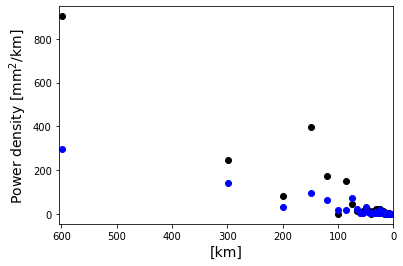

In [164]:
plt.plot(1/f1,Pxx_den1,'ok')
plt.plot(1/f2,Pxx_den2,'ob')
plt.xlim([605,0])
plt.xlabel('[km]',fontsize=14)
plt.ylabel('Power density [mm$^2$/km]',fontsize=14)

In [136]:
from multiprocessing import Pool 
import functools

In [134]:
def accum_explained_var(i,dx=0.25):
    
    data = pwv_1D_xarray[:,i] # along latitude
    tot_var = data.values.var()
    f, Pxx_den = signal.periodogram(data.values, 1/dx) # sampling rate = 1/0.25 km^-1

    accum_var = np.zeros(len(Pxx_den))
    # cumulative explained variance
    for k in range(len(Pxx_den)):
        accum_var[k] = np.trapz(Pxx_den[:k],f[:k])
        
    return accum_var/tot_var

In [ ]:
%%time

data = pwv_insar_abs.pwat[0,:,800].fillna(0) # along latitude
f, Pxx_den = signal.periodogram(data.values, 1/0.25) # sampling rate = 1/0.25 km^-1
cumu_explained_insar = np.zeros((len(pwv_insar_abs.time),len(f)))

# InSAR
for t in range(len(pwv_insar_abs.time)):
    
    pwv_1D_xarray = pwv_insar_abs.pwat[t,:,:].fillna(0)
    
    process_pool = Pool()
    df = process_pool.map(functools.partial(accum_explained_var,dx=0.25),range(len(pwv_insar_abs.longitude)))
    cumu_explained_insar[t,:] = np.nanmean(np.asarray(df),axis=0)
    process_pool.close()
    process_pool.join()
    
cumu_explained_insar = xr.DataArray(cumu_explained_insar,dims=['time','xscale'],
                                    coords=[pwv_insar_abs.time,1/f])

In [137]:
%%time

data = pwv_hrrr_abs.pwat[0,:,67].fillna(0) # along latitude
f, Pxx_den = signal.periodogram(data.values, 1/3) # sampling rate = 1/0.25 km^-1
cumu_explained_hrrr = np.zeros((len(pwv_insar_abs.time),len(f))) # spectral estimates

# HRRR
for t in range(len(pwv_insar_abs.time)):
    
    pwv_1D_xarray = pwv_hrrr_abs.pwat[t,:,:].fillna(0)
    
    process_pool = Pool()
    df = process_pool.map(functools.partial(accum_explained_var,dx=3),range(len(pwv_hrrr_abs.longitude)))
    cumu_explained_hrrr[t,:] = np.nanmean(np.asarray(df),axis=0)
    process_pool.close()
    process_pool.join()
    
cumu_explained_hrrr = xr.DataArray(cumu_explained_hrrr,dims=['time','xscale'],
                                    coords=[pwv_insar_abs.time,1/f])

CPU times: user 11.4 s, sys: 1min 31s, total: 1min 43s
Wall time: 1min 49s


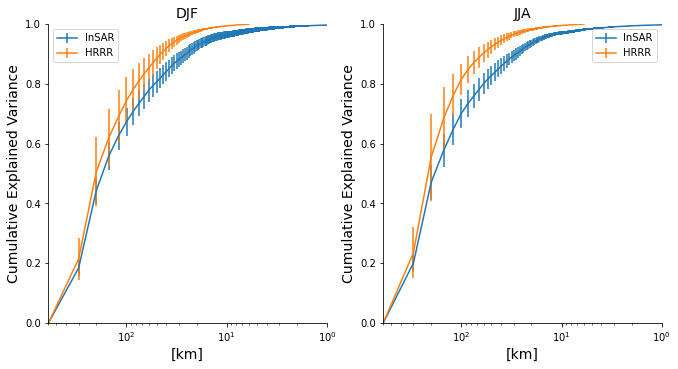

In [169]:
fig,ax = plt.subplots(1,2,figsize=(11,5.5))

for i,season in enumerate(['DJF','JJA']):
    mn = cumu_explained_insar.groupby('time.season').mean()
    var = cumu_explained_insar.groupby('time.season').std()
    mn2 = cumu_explained_hrrr.groupby('time.season').mean()
    var2 =  cumu_explained_hrrr.groupby('time.season').std()
    
    #ax[i].plot(tmp.xscale , mn.sel(season=season),'-o',label='InSAR')
    ax[i].errorbar(tmp.xscale, mn.sel(season=season), yerr=var.sel(season=season),label='InSAR')
    #ax[i].plot(tmp2.xscale , mn2.sel(season=season),'-s',label='HRRR')
    ax[i].errorbar(tmp2.xscale , mn2.sel(season=season), yerr=var2.sel(season=season),label='HRRR')
    ax[i].set_xlim([605,1])
    ax[i].set_ylim([0,1])
    ax[i].legend()
    ax[i].set_xscale('log')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_title(season, fontsize=14)
    ax[i].set_xlabel('[km]',fontsize=14)
    ax[i].set_ylabel('Cumulative Explained Variance', fontsize=14)
#fig.savefig('/data2/willytsai/InSAR_HRRR/Cumulative_explaned_var_DJF&JJA.png',dpi=200,
#           bbox_inches='tight',transparent=False)

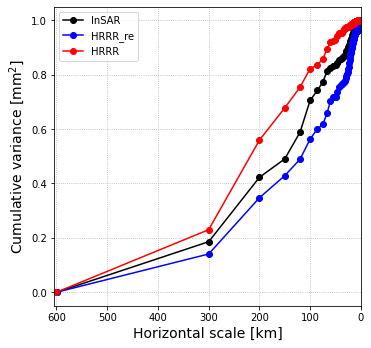

In [56]:
fig = plt.figure(figsize=(5.5,5.5))

plt.plot(1/f1,accum_var_insar/tot_var_insar,'-ok',label='InSAR')
plt.plot(1/f2,accum_var_hrrr/tot_var_hrrr,'-ob',label='HRRR_re')
plt.plot(1/f3,accum_var_ori/tot_var_ori,'-or',label='HRRR')

plt.xlim([605,0])
plt.xlabel('Horizontal scale [km]',fontsize=14)
plt.ylabel('Cumulative variance [mm$^2$]',fontsize=14)
plt.grid(linestyle=':')
plt.legend()

In [ ]:
length = (pwv_insar_abs.latitude[-1]-pwv_insar_abs.latitude[0]).values*100

In [ ]:
N = len(insar_test[:,800])
xf = fft.fftfreq(N, 1/0.25)[:N//2]
yf = fft.fft(insar_test[:,800].values)
yf2 = fft.fft(hrrr_test[:,800])

In [ ]:
fig = plt.figure(figsize=(10,3))
plt.plot(length/np.arange(N//2), 2.0/N*np.abs(yf[0:N//2]),'ok')
plt.plot(length/np.arange(N//2), 2.0/N*np.abs(yf2[0:N//2]),'ob')
plt.xlim([605,0])
plt.xlabel('Horizonal scale [km]',fontsize=13)
plt.ylabel('Amplitude [mm]',fontsize=13)

In [ ]:
%%time
pwv_insar_spectrum = np.zeros((len(pwv_insar_abs.time),pwv_insar_abs.latitude.size//2))
pwv_hrrr_spectrum = np.copy(pwv_insar_spectrum)

for t in range(pwv_insar_abs.pwat.shape[0]):
    
    insar_test = pwv_insar_abs.pwat[t,:,:].fillna(0).values
    hrrr_test = pwv_hrrr_abs.pwat[t,:,:]
    hrrr_test = remap_hrrr2SAR(hrrr_test)
    hrrr_test[insar_test==0] = 0

    Pxx_den_insar, Pxx_den_hrrr = [], []

    for i in range(insar_test.shape[1]):

        N = len(insar_test[:,i])
        xf = fft.fftfreq(N, 1/0.25)[:N//2]
        yf = fft.fft(insar_test[:,i])
        yf2 = fft.fft(hrrr_test[:,i])

        Pxx_den_insar.append(1.0/N*np.abs(yf[0:N//2]))
        Pxx_den_hrrr.append(1.0/N*np.abs(yf2[0:N//2]))

    Pxx_den_insar = np.asarray(Pxx_den_insar)
    Pxx_den_hrrr = np.asarray(Pxx_den_hrrr)
    
    pwv_insar_spectrum[t,:] = Pxx_den_insar.mean(axis=0)
    pwv_hrrr_spectrum[t,:] = Pxx_den_hrrr.mean(axis=0)

In [ ]:
pwv_insar_spectrum_xr = xr.DataArray(pwv_insar_spectrum, dims=['time','xscale'],
                              coords=[pwv_insar_abs.time,length/np.arange(N//2)])
pwv_hrrr_spectrum_xr = xr.DataArray(pwv_hrrr_spectrum, dims=['time','xscale'],
                              coords=[pwv_insar_abs.time,length/np.arange(N//2)])

In [ ]:
tmp = pwv_insar_spectrum_xr.groupby('time.season').mean('time',skipna=True)
tmp2 = pwv_hrrr_spectrum_xr.groupby('time.season').mean('time',skipna=True)

In [ ]:
fig = plt.figure(figsize=(6,6))

plt.plot(tmp.xscale,tmp.sel(season='DJF'),'ok')
plt.plot(tmp.xscale,tmp.sel(season='MAM'),'or')
plt.plot(tmp.xscale,tmp.sel(season='JJA'),'og')
plt.plot(tmp.xscale,tmp.sel(season='SON'),'ob')

plt.plot(tmp.xscale,tmp2.sel(season='DJF'),'sk')
plt.plot(tmp.xscale,tmp2.sel(season='MAM'),'sr')
plt.plot(tmp.xscale,tmp2.sel(season='JJA'),'sg')
plt.plot(tmp.xscale,tmp2.sel(season='SON'),'sb')

plt.xlim([605,0])
plt.

In [ ]:
plt.plot(length/np.arange(N//2),(np.abs(Pxx_den_insar-Pxx_den_hrrr)).mean(axis=0),'ok')
plt.errorbar(length/np.arange(N//2),(np.abs(Pxx_den_insar-Pxx_den_hrrr)).mean(axis=0),
             yerr=(np.abs(Pxx_den_insar-Pxx_den_hrrr)).std(axis=0))
#plt.plot((Pxx_den_insar-Pxx_den_hrrr).std(axis=0))
#plt.plot(Pxx_den_hrrr.mean(axis=0))
plt.xlim([605,0])
plt.xlabel('Horizonal scale [km]',fontsize=13)
plt.ylabel('Amplitude [mm]',fontsize=13)

In [ ]:
insar_test[:,800].shape